<a href="https://colab.research.google.com/github/Virajbiz98/Python_Learning/blob/main/LangGraph/chatbot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install langchain==0.3.24 -q
!pip install openai -q
# !pip install -q -U google-generativeai
!pip install langgraph -q
!pip install langchain_openai -q

In [ ]:
from typing import TypedDict, List
from langchain_core.messages import HumanMessage

In [ ]:
class Agentstate(TypedDict):
  messages: List[HumanMessage]

In [ ]:
import os
from google.colab import userdata

os.environ['OPENAI_API_KEY'] = userdata.get('API_KEY')

In [ ]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(
    model = "gpt-4.1",
    temperature=0
)

In [ ]:
def chatbot(state: Agentstate) -> Agentstate:
  response = llm.invoke(state["messages"])
  print(f"\nAI: {response.content}")
  return state

In [ ]:
from langgraph.graph import StateGraph, START, END

workflow = StateGraph(Agentstate)

workflow.add_node("chatbot", chatbot)

workflow.add_edge(START, "chatbot")
workflow.add_edge("chatbot", END)

app = workflow.compile()

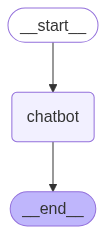

In [ ]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [ ]:
user_input = input("Enter a Query: ")
result = app.invoke({"messages": [HumanMessage(content=user_input)]})
print(result)

Enter a Query: exit


RateLimitError: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}

In [ ]:
from IPython import get_ipython
from IPython.display import display
# %%
!pip install langchain==0.3.24 -q
# !pip install openai -q # We will no longer use the openai library
!pip install -q -U google-generativeai
!pip install langgraph -q
# !pip install langchain_openai -q # We will no longer use the langchain_openai library
!pip install langchain_google_genai -q # Install the necessary library for Google GenAI

In [ ]:
from typing import TypedDict, List, Union
from langchain_core.messages import HumanMessage, AIMessage



In [ ]:

class Agentstate(TypedDict):
  messages: List[Union[HumanMessage,AIMessage]]

In [ ]:
import os
from google.colab import userdata
os.environ['GOOGLE_API_KEY'] = userdata.get('GOOGLE_API_KEY')

In [ ]:
from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(
    model = "gemini-2.0-flash",
    temperature=0
)

In [ ]:

def chatbot(state: Agentstate) -> Agentstate:
  response = llm.invoke(state["messages"])
  state["messages"].append(AIMessage(content=response.content))
  print(f"\nAI: {response.content}")
  return state

In [ ]:
from langgraph.graph import StateGraph, START, END

workflow = StateGraph(Agentstate)

workflow.add_node("chatbot", chatbot)

workflow.add_edge(START, "chatbot")
workflow.add_edge("chatbot", END)

app = workflow.compile()

In [ ]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))


In [ ]:

user_input = input("Enter a Query: ")
result = app.invoke({"messages": [HumanMessage(content=user_input)]})
print(result)

In [ ]:
history = []

user_input = input("Enter a Query: ")
while user_input != "exit":
  history.append(HumanMessage(content=user_input))
  result = app.invoke({"messages": history } )
  history = result["messages"]
  user_input = input("Enter a Qeury: ")